# IRS-combined TMT Intensities for PXD011691

## Quality control check notebook

### Phil Wilmarth, PSR Core OHSU

### February 20, 2023

---

- [Overview](#overview) 
- [Data loading and data frame construction](#load_data)
- [Starting distributions and clustering](#start_data)
- [TMM normalization and final clustering](#TMM)
- [Final CV distributions](#CVs)
- [Final sample-to-sample within group similarity](#scatter)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

Data from the 10-fraction TMT part of [PXD011691](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD011691) described in [this paywalled paper](https://pubs.acs.org/doi/abs/10.1021/acs.jproteome.8b00898). The paper nominally compares single-shot DIA analyses (library and library-free with [Spectronaut](https://biognosys.com/software/spectronaut/)) to fractionated TMT-labeled analyses. The number of fractions for the TMT experiment was designed to use a similar total LC-MS time as the single-shot method. The samples were predominantly digests of 10 purchased mouse brain samples. 

All the wet bench work was done at one lab. The final mass spec samples for the low-pH reverse phase chromatography runs were split and two laboratories generated data from the same instrument models. The two lab datasets are, in essence, LC-MS technical replicates. One possible data comparison is between the two labs by either DIA or TMT methods.

Each lab did the DIA and TMT experiments. Another comparison would be between DIA and TMT from each lab site. The samples are the same and the study designs, while different, are how studies with each method would typically be done. The "proteome" comparison is challenging for several reasons. We need to define what we mean by proteomes. We need to create and describe procedures for comparing proteomes. We do not know how similar or different single shot versus fractionated proteomes are if we used only one quantitative proteomics technique. We do not know if proteomes from DIA are similar to DDA proteomes. We do not know how stable isotope labeled proteomes compare to label-free proteomes. We do not know how different data analysis pipelines affect proteomes. This is a difficult problem.

The publication also spiked-in human UPS2 protein digests to the mouse background. Much of the paper focuses on concepts of accuracy and precision using the UPS2 proteins. However, the spike-in design is poor (a common theme among spike-in experimental designs), and the data is not worth the time to analyize. Major flaws in the spike-in experiment are high homology between human and mouse house-keeping proteins (the UPS proteins are mostly common house-keeping proteins), picking UPS2 instead of UPS1 (UPS2 has proteins in groups of 8 that have 5 decades of concentration difference), doing 5 dilutions of a spike-in sample that already has dilutions (kind of a dilution squared situation) for 10 samples (comparisons are n=2 cases), and very low levels of UPS2 proteins that compromise detectability (only 12-19 of the 48 proteins could be detected). The UPS2 spike-in is an unnecessary distraction.

### This notebook

This notebook will look at directly comparing the data from both BGS and FLI labs. We will do that using the internal reference scaling (IRS) method to combine data from multiple TMT plexes. We will see how similar the mouse brain background proteins are in each TMT plex and how the exact same sample compares when characterized with TMT labeling done in two different labs, on different instruments, and at different times.

### Sample Key:

This is a guessed sample key based on the total intensity of UPS2 proteins to the total intensity of mouse proteins for each TMT channel (after excluding decoys and contaminants).

TMT10 Label Reagent|Sample_ID
:---:|:---
126C|S4-1 
127N|S2-1  
127C|S5-1  
128N|S4-2 
128C|S3-1  
129N|S2-2  
129C|S3-2
130N|S1-1 
130C|S5-2
131N|S1-2

--- 

Data were reprocessed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (**Wilmarth 2009**) using a current canonical mouse sequence collection (from UniProt with 21K sequences). There were several issues with the Proteome Discoverer v2.2 TMT data presented in the paper. The FASTA file for mouse was the somewhat incomplete UniProt Swiss-Prot (less than 17K sequences from 2016), Mascot was used for PSM identification of the low-res ion trap data in the SPS-MS3 method with so-so parameters, signal-to-noise ratios were used for reporter ions (measurements have units, folks), the protein inference method in PD was not described, and the sample key (what TMT tags were used for the samples) was not specified (neither in the paper nor the repository).

An internal reference scaling (IRS) approach (**Plubell 2017**) was used to combine the TMT data from the two sites. There were no internal reference standards *per se* in the experimental design. It was the same 10 samples run at both sites, though. I chose the two S5 (highest UPS2 spike-in levels) samples in each plex to be the internal standard proxies. 

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

## Load the necessary R libraries

In [20]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)
library(dendextend)

## Define common functions for notebook use

In [21]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the IRS-normalized data

The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is relatively straightforward.

We need to drop contaminant and decoy proteins, and proteins with missing sets of reporter ions. We extract the accessions column, the SLNorm data columns, and IRSNorm data columns. 

In [22]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", 
                        guess_max = 7017)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))
data_sl <- select(data_all, contains("SLNorm_"))
data_irs <- select(data_all, contains("IRSNorm_"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.



[1] 6260

### Organize data by UPS2 spike-in levels

In [23]:
# define the groups
BGS_sl <- select(data_sl, contains("_BGS-"))
BGS_sl <- data.frame(select(BGS_sl, contains("-S1-")),
                     select(BGS_sl, contains("-S2-")),
                     select(BGS_sl, contains("-S3-")),
                     select(BGS_sl, contains("-S4-")))
FLI_sl <- select(data_sl, contains("_FLI-"))
FLI_sl <- data.frame(select(FLI_sl, contains("-S1-")),
                     select(FLI_sl, contains("-S2-")),
                     select(FLI_sl, contains("-S3-")),
                     select(FLI_sl, contains("-S4-")))

POOL_sl <- select(data_sl, contains("POOL"))

BGS_irs <- select(data_irs, contains("_BGS-"))
BGS_irs <- data.frame(select(BGS_irs, contains("-S1-")),
                      select(BGS_irs, contains("-S2-")),
                      select(BGS_irs, contains("-S3-")),
                      select(BGS_irs, contains("-S4-")))
FLI_irs <- select(data_irs, contains("_FLI-"))
FLI_irs <- data.frame(select(FLI_irs, contains("-S1-")),
                      select(FLI_irs, contains("-S2-")),
                      select(FLI_irs, contains("-S3-")),
                      select(FLI_irs, contains("-S4-")))

POOL_irs <- select(data_irs, contains("POOL"))

# put together in one frame
tmt_sl <- cbind(BGS_sl, FLI_sl, POOL_sl)
tmt_irs <- cbind(BGS_irs, FLI_irs, POOL_irs)

cat(colnames(tmt_sl), sep = "\n")

SLNorm_BGS.S1.1_1
SLNorm_BGS.S1.2_1
SLNorm_BGS.S2.1_1
SLNorm_BGS.S2.2_1
SLNorm_BGS.S3.1_1
SLNorm_BGS.S3.2_1
SLNorm_BGS.S4.1_1
SLNorm_BGS.S4.2_1
SLNorm_FLI.S1.1_2
SLNorm_FLI.S1.2_2
SLNorm_FLI.S2.1_2
SLNorm_FLI.S2.2_2
SLNorm_FLI.S3.1_2
SLNorm_FLI.S3.2_2
SLNorm_FLI.S4.1_2
SLNorm_FLI.S4.2_2
SLNorm_POOL-BGS-S5-1_1
SLNorm_POOL-BGS-S5-2_1
SLNorm_POOL-FLI-S5-1_2
SLNorm_POOL-FLI-S5-2_2


## <a name="start_data"></a>Check starting data

We will define some column indexes for each condition, set some colors for plotting, and see how the data cluster by condition. We will look at the clustering before IRS and after IRS. The samples are colored by treatment groups.

In [24]:
# define which columns go with each group
BGS <- 1:8
FLI <- 9:16
POOL <- 17:20

S1 <- c(1, 2, 9, 10)
S2 <- c(3, 4, 11, 12)
S3 <- c(5, 6, 13, 14)
S4 <- c(7, 8, 15, 16)

# set some colors by treatment group
colors = c(rep('red', 8), rep('blue', 8), rep('black', 4))

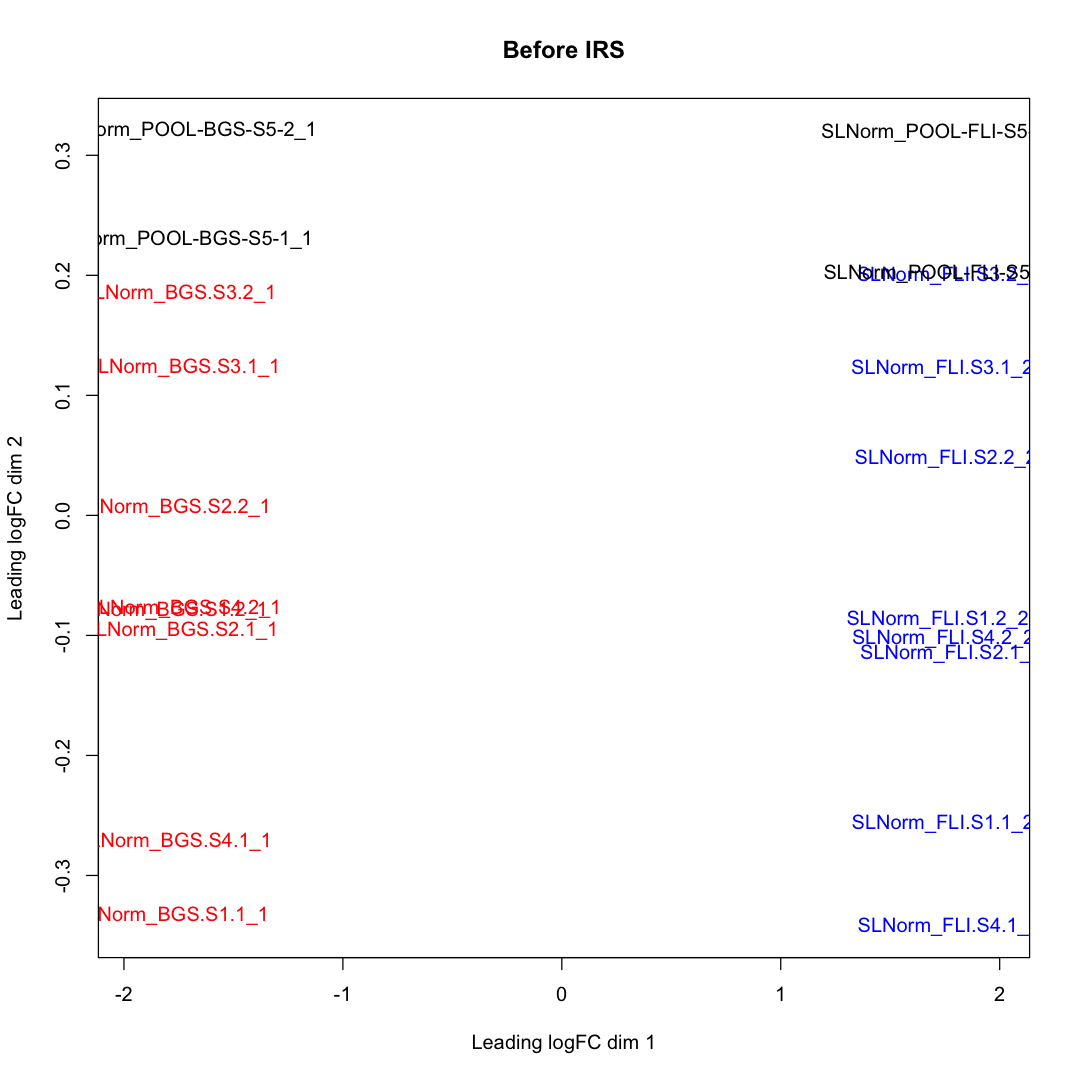

In [25]:
# make default plot sizes a little bigger
set_plot_dimensions(9, 9)

# check clustering before IRS
plotMDS(log2(tmt_sl), main = "Before IRS", col = colors)

### Samples cluster by TMT plex

Samples from each of the plexes are stacked either on the far left or the far right. The pooled standard channels are similar to each other within each plex, but not at all similar between plexes. The proxy standards are similar biological replicate samples in both plexes (sites).

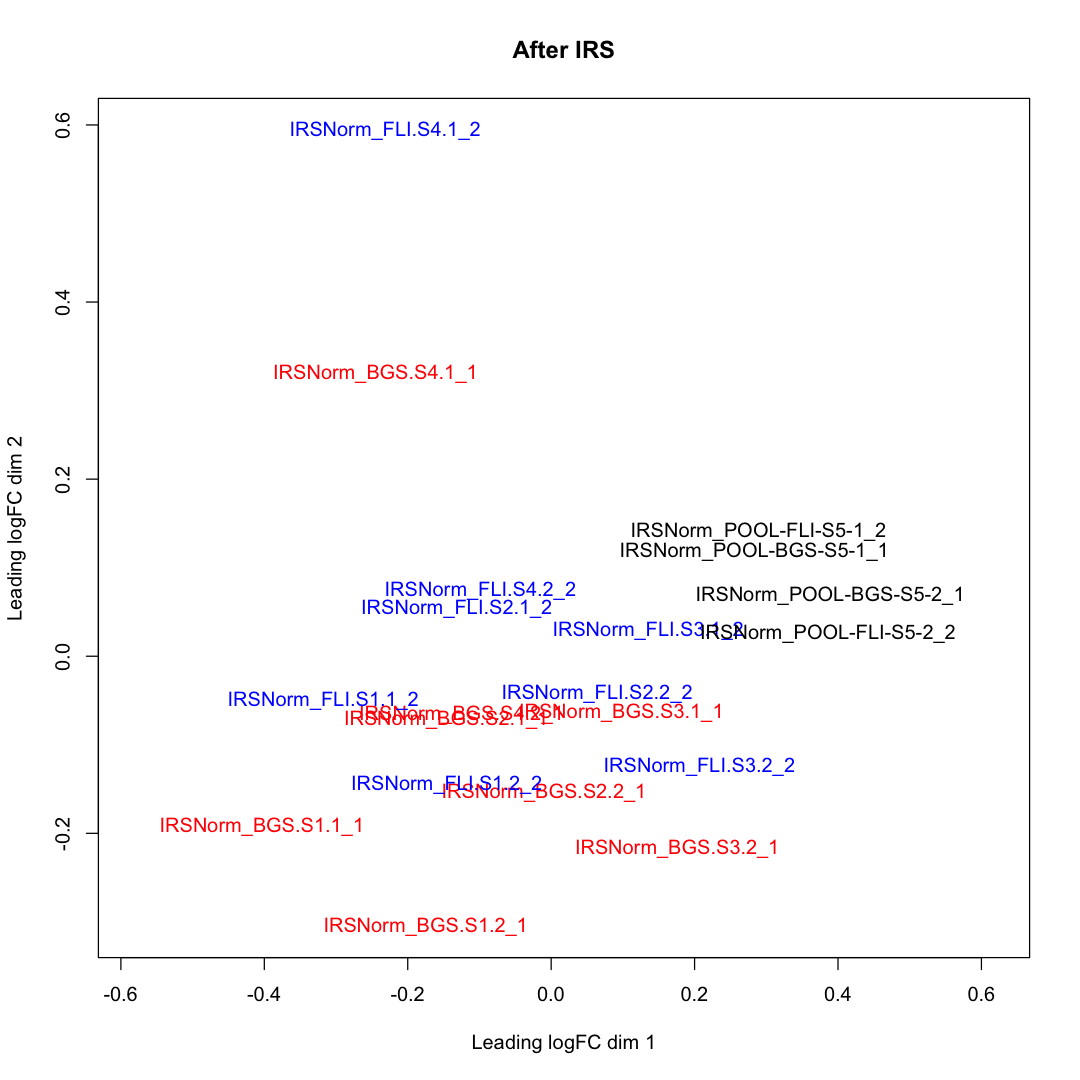

In [26]:
# clustering after IRS
plotMDS(log2(tmt_irs), main = "After IRS", col = colors)

### All pooled standard channels cluster together after IRS

The 4 proxy standard channels (in black) cluster together (more or less) after IRS. We do not have much separation between the red and blue clusters.

## Check the reference channels before and after IRS

The intensities after IRS should be very similar because the IRS method will make the average reference protein intensities identical in each plex. In the before IRS figure, reference channels are similar within plex, but different between plexes. The scatter between plexes is because of the random selection for MS2 scans. This is highly variable feature-by-feature and would not be similar between LC runs or TMT plexes. The IRS method removes that variation.

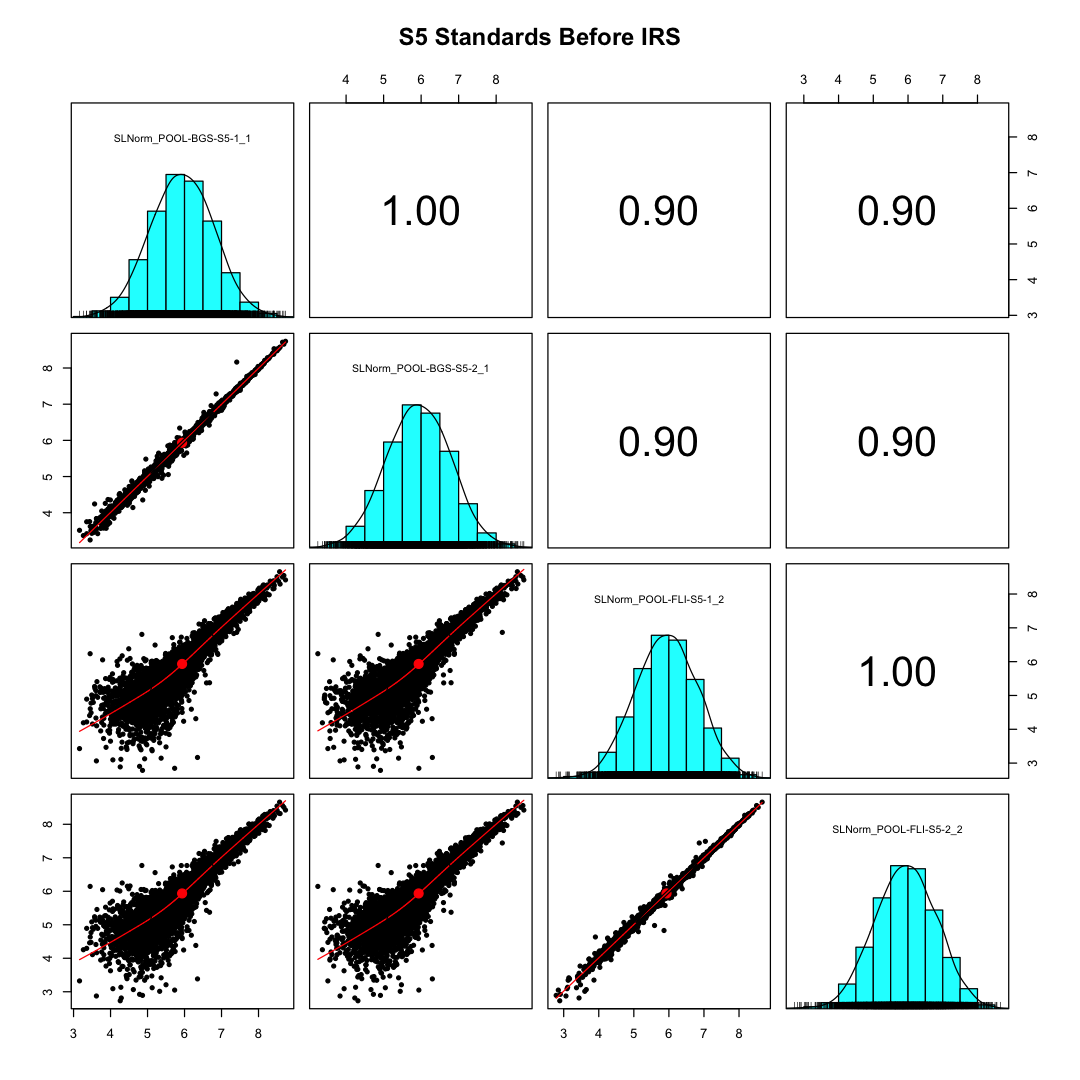

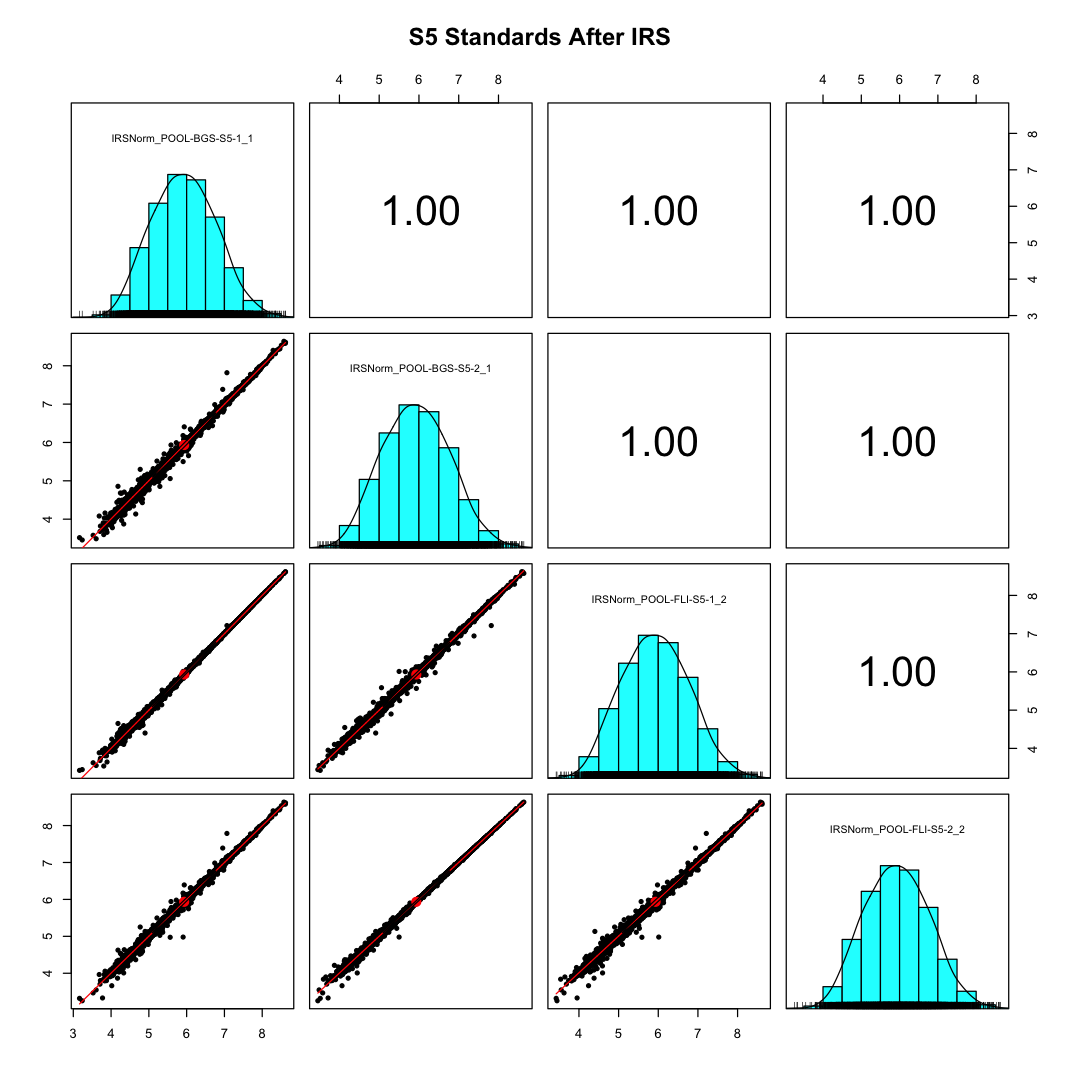

In [27]:
# check the internal reference standard channels
pairs.panels(log10(POOL_sl), main = "S5 Standards Before IRS")
pairs.panels(log10(POOL_irs), main = "S5 Standards After IRS")

### IRS make identical samples nearly identical

The before IRS data shows how severe the random sampling distorts the data.

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization. We will double check if the TMM normalization changed the clustering that we had above. We compute the normalized intensities with the `apply_tmm_factors function`.

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.


Library size factors:
 IRSNorm_BGS.S1.1_1 -> 1.002541
 IRSNorm_BGS.S1.2_1 -> 1.000022
 IRSNorm_BGS.S2.1_1 -> 1.004270
 IRSNorm_BGS.S2.2_1 -> 1.000551
 IRSNorm_BGS.S3.1_1 -> 0.999244
 IRSNorm_BGS.S3.2_1 -> 0.999568
 IRSNorm_BGS.S4.1_1 -> 1.006565
 IRSNorm_BGS.S4.2_1 -> 1.001266
 IRSNorm_FLI.S1.1_2 -> 0.998081
 IRSNorm_FLI.S1.2_2 -> 1.000153
 IRSNorm_FLI.S2.1_2 -> 0.997905
 IRSNorm_FLI.S2.2_2 -> 0.999325
 IRSNorm_FLI.S3.1_2 -> 0.999885
 IRSNorm_FLI.S3.2_2 -> 0.998661
 IRSNorm_FLI.S4.1_2 -> 0.994852
 IRSNorm_FLI.S4.2_2 -> 0.998516
 IRSNorm_POOL-BGS-S5-1_1 -> 0.998295
 IRSNorm_POOL-BGS-S5-2_1 -> 1.001061
 IRSNorm_POOL-FLI-S5-1_2 -> 0.999675
 IRSNorm_POOL-FLI-S5-2_2 -> 0.999678

Trimmed mean of M-values (TMM) factors:
 IRSNorm_BGS.S1.1_1 -> 1.006651
 IRSNorm_BGS.S1.2_1 -> 0.985029
 IRSNorm_BGS.S2.1_1 -> 1.001660
 IRSNorm_BGS.S2.2_1 -> 0.992239
 IRSNorm_BGS.S3.1_1 -> 0.986670
 IRSNorm_BGS.S3.2_1 -> 1.022305
 IRSNorm_BGS.S4.1_1 -> 1.017615
 IRSNorm_BGS.S4.2_1 -> 0.985558
 IRSNorm_FLI.S1.1_2 

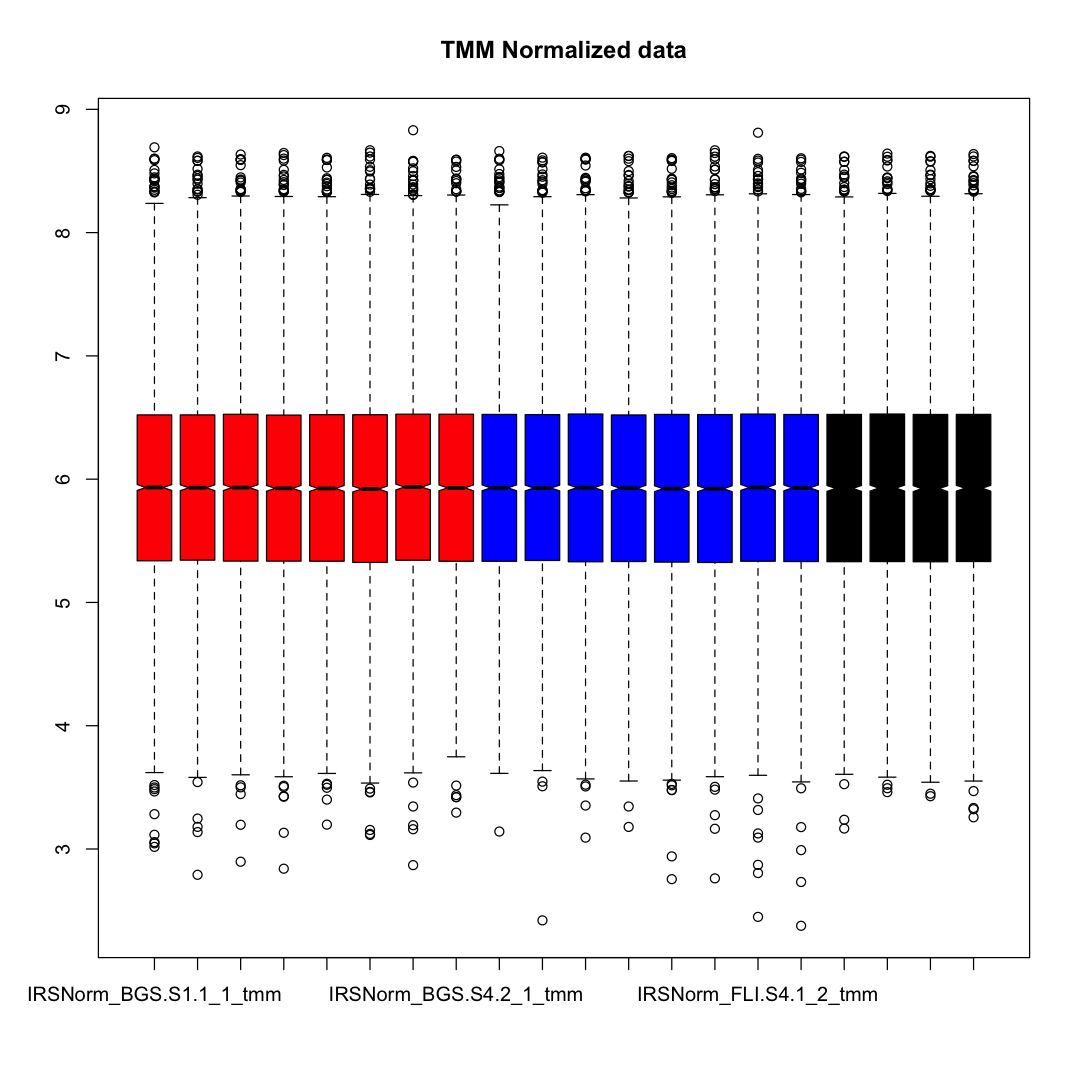

In [28]:
# get the biological sample data into a DGEList object
group = c(rep("BGS", length(BGS)), rep("FLI", length(FLI)), rep("POOL", length(POOL)))
y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = colors)

### The TMM factors are mostly near 1.0

The boxplots look excellent.

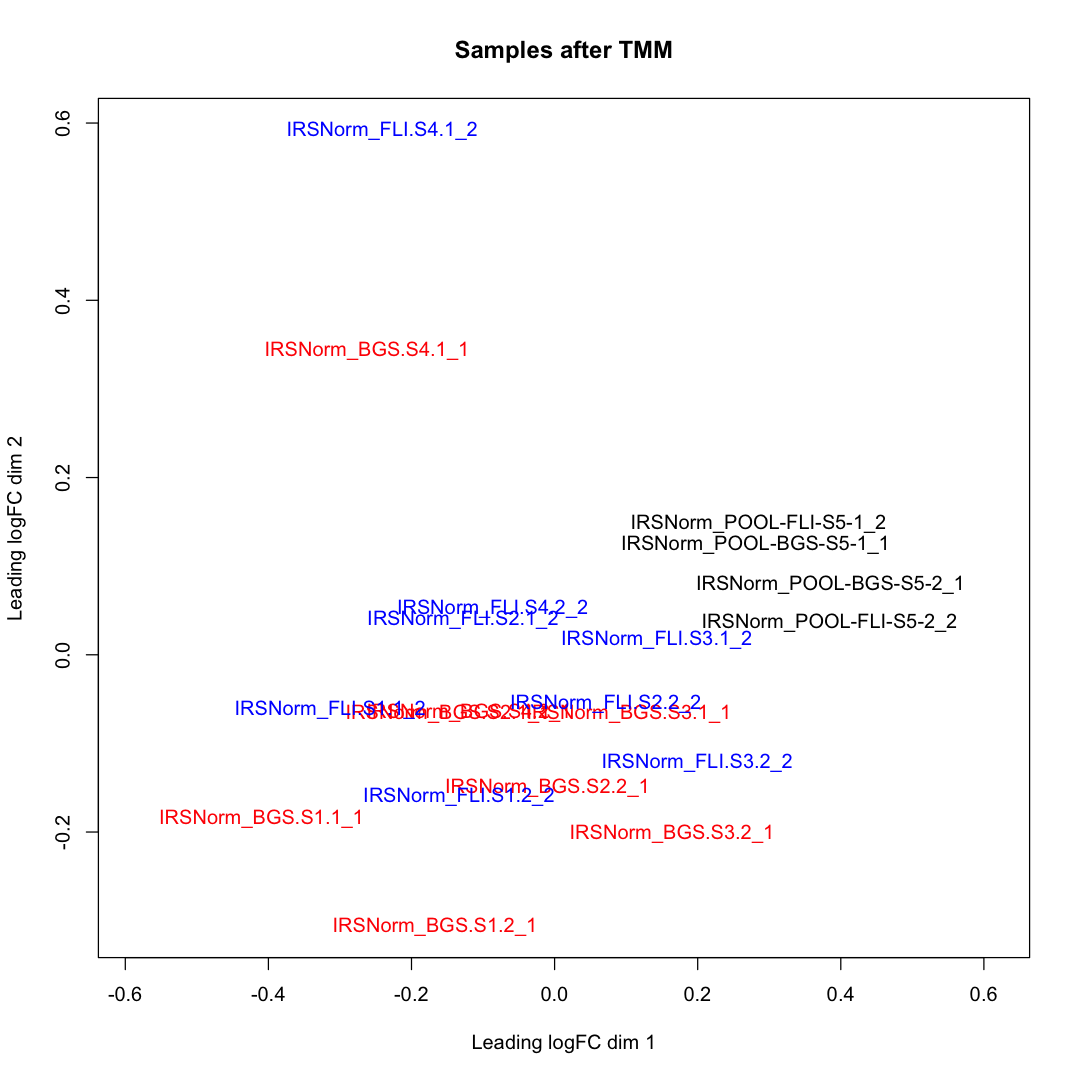

In [29]:
# check the clustering
plotMDS(y, col = colors, main = "Samples after TMM")

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the two sites (8 channels per site because we used two for IRS).

In [30]:
# put CVs in data frames to simplify plots and summaries
cv_sl <- data.frame(BGS = CV(tmt_sl[BGS]), FLI = CV(tmt_sl[FLI]))
cv_tmm <- data.frame(BGS = CV(tmt_tmm[BGS]), FLI = CV(tmt_tmm[FLI])) 

# see what the median CV values are
medians <- apply(cv_sl, 2, FUN = median)
print("SL-norm median CVs by condition (%)")
cat(paste(names(medians), round(medians, 2), sep = ": "), sep = "\n")

medians <- apply(cv_tmm, 2, FUN = median)
print("Final (IRS+TMM) median CVs by condition (%)")
cat(paste(names(medians), round(medians, 2), sep = ": "), sep = "\n")

[1] "SL-norm median CVs by condition (%)"
BGS: 5.89
FLI: 6.18
[1] "Final (IRS+TMM) median CVs by condition (%)"
BGS: 5.66
FLI: 5.95


#### The median CVs are improved (a little) by TMM normalization

Median CVs are slightly improved by TMM normalization. The IRS script does some normalizations already and there is not much left for TMM to improve on. 

### Use ggplot to visualize the CV distributions

We will compare the starting data (before IRS) to the final TMM normalized data (IRS plus TMM).

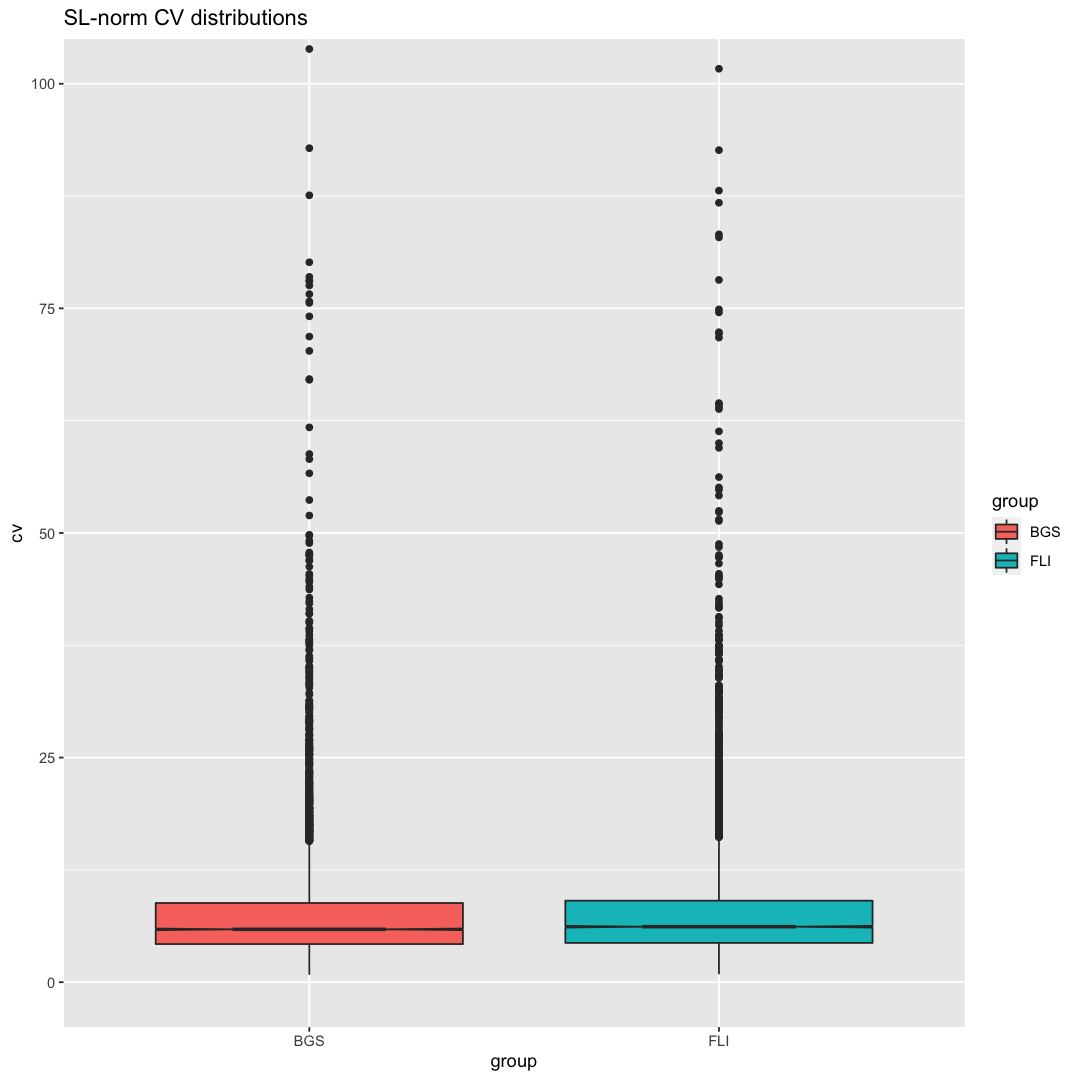

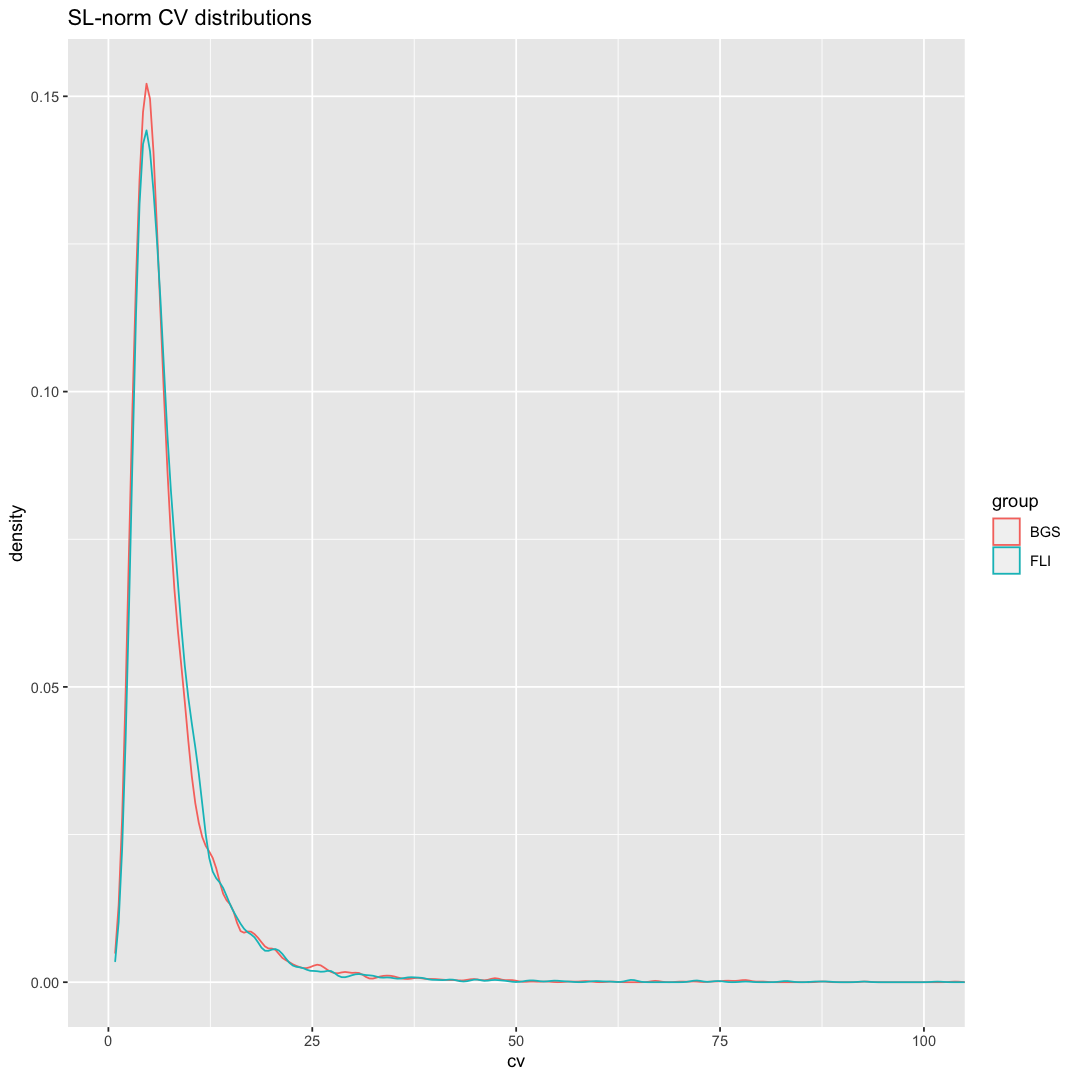

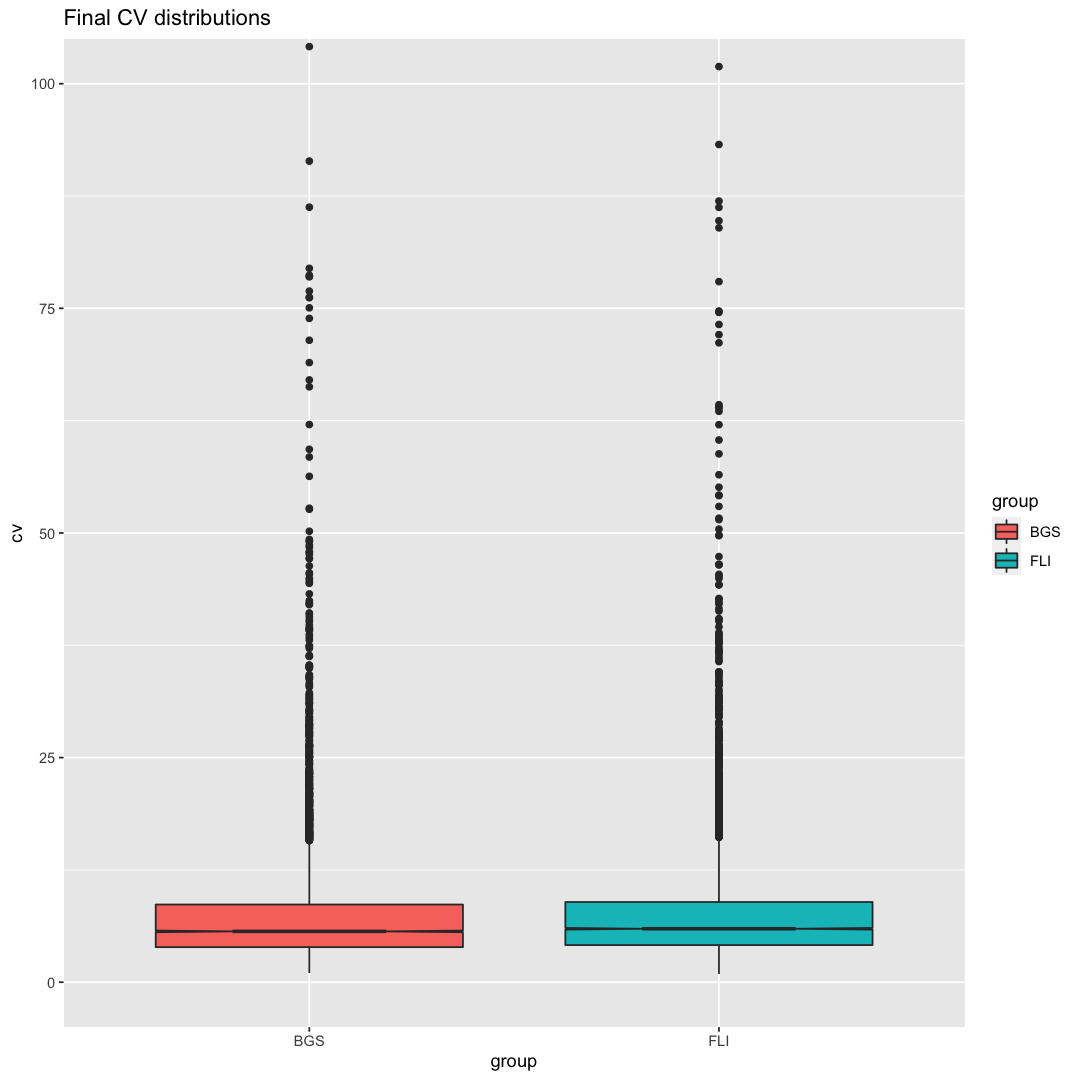

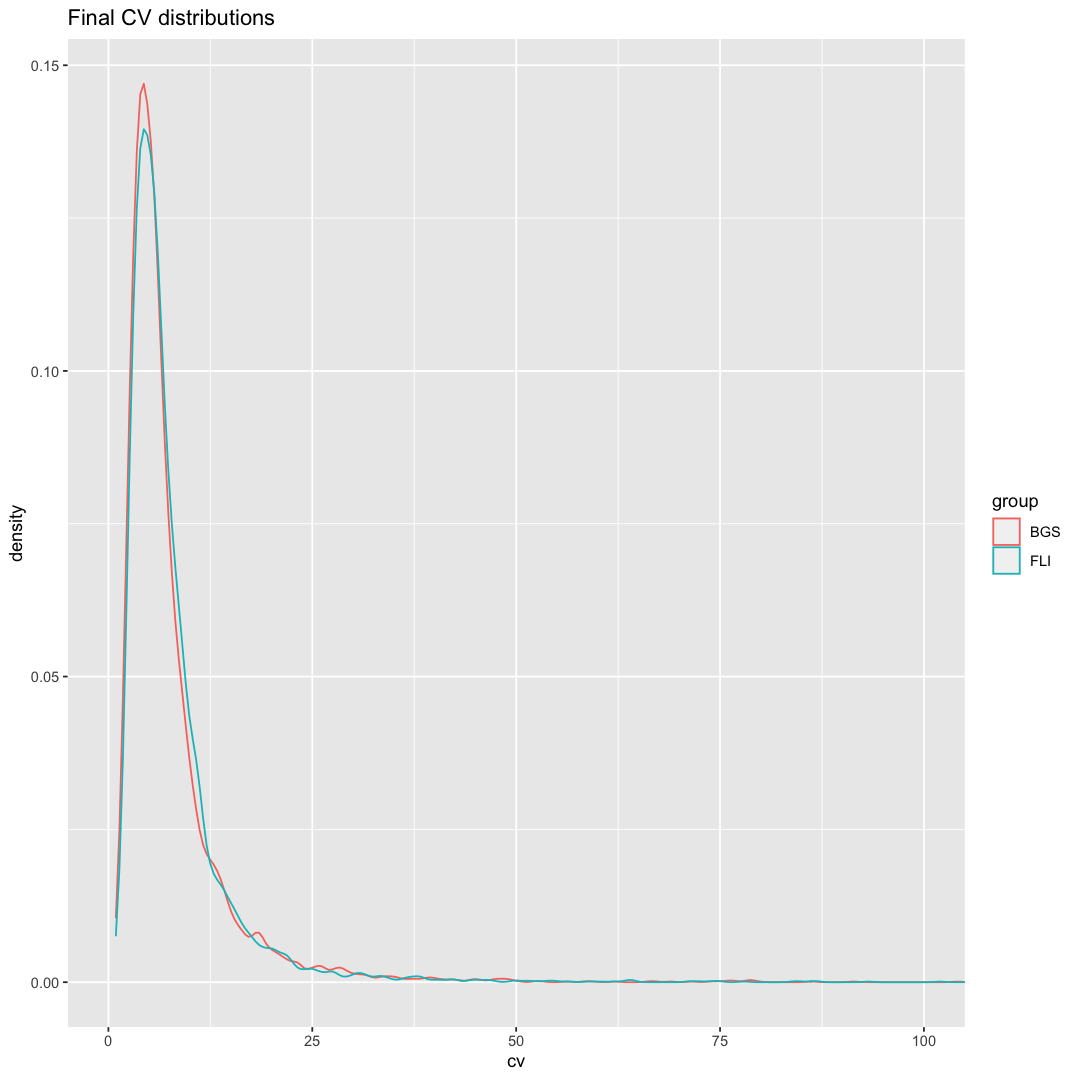

In [31]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_sl <- gather(cv_sl, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_sl, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_cartesian(ylim = c(0, 100)) +
  ggtitle("SL-norm CV distributions")

# density plots
ggplot(long_cv_sl, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("SL-norm CV distributions")

# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  coord_cartesian(ylim = c(0, 100)) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("Final CV distributions")

### CV distributions from both sites are nearly identical

There is not much difference before or after TMM in this case, but the CV distributions from either site are nearly identical.

## <a name="scatter"></a>Compare samples within each condition

We will use scatter plot grids to see how similar samples within groups (the UPS2 spike-in levels) are to each other. **Remember, we did the IRS adjustment with the S5 sample values only.** The data for S1 to S4 is, to a large extent, mathematically independent (there are low levels of [channel cross talk](https://github.com/pwilmart/TMT_channel_cross_talk). Data for S1 to S4 replicate pairs was **NOT** used in the IRS adjustment. This approach lets us adjust between labs using IRS and the S5 channels **AND** validate the adjustment method using the S1 to S4 samples. 

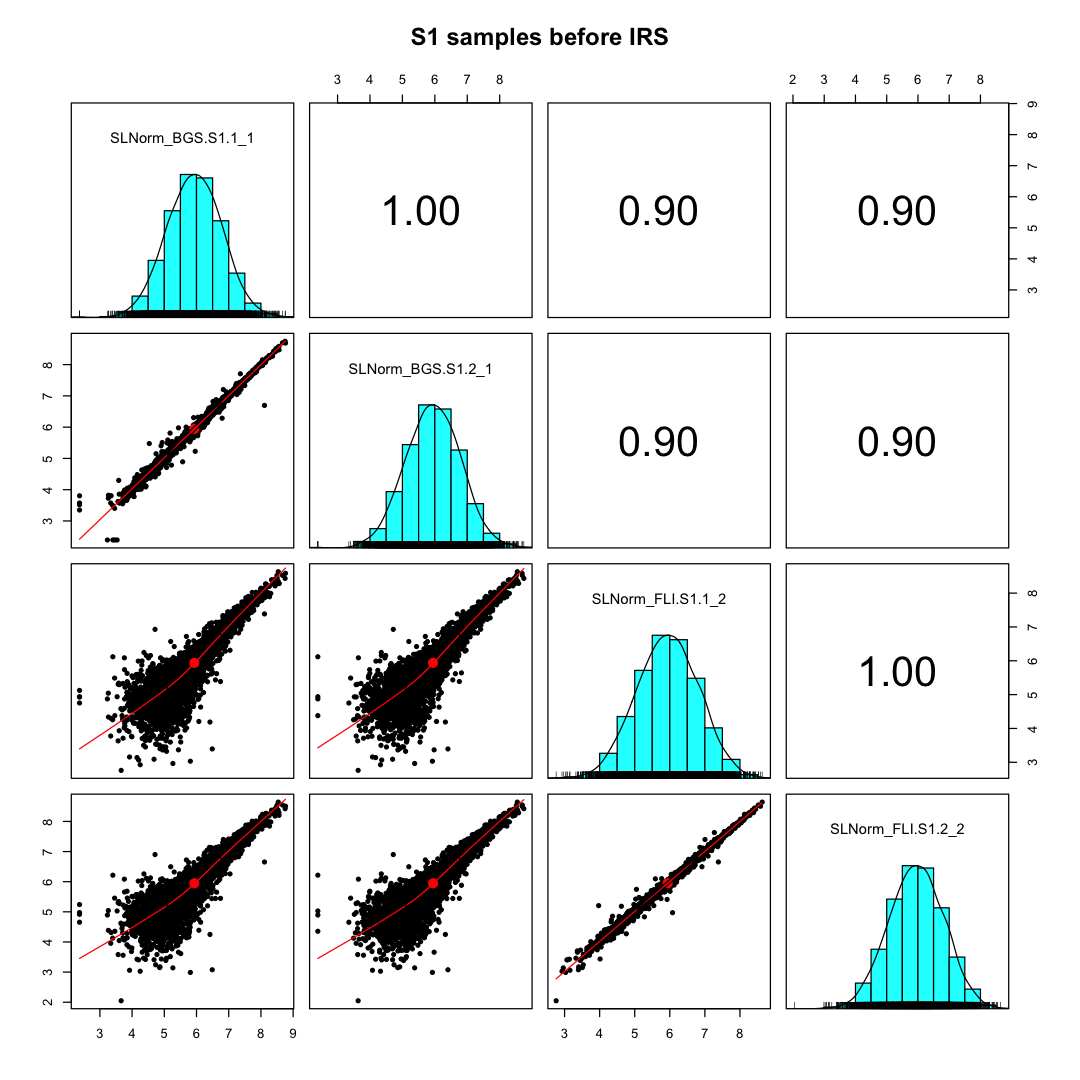

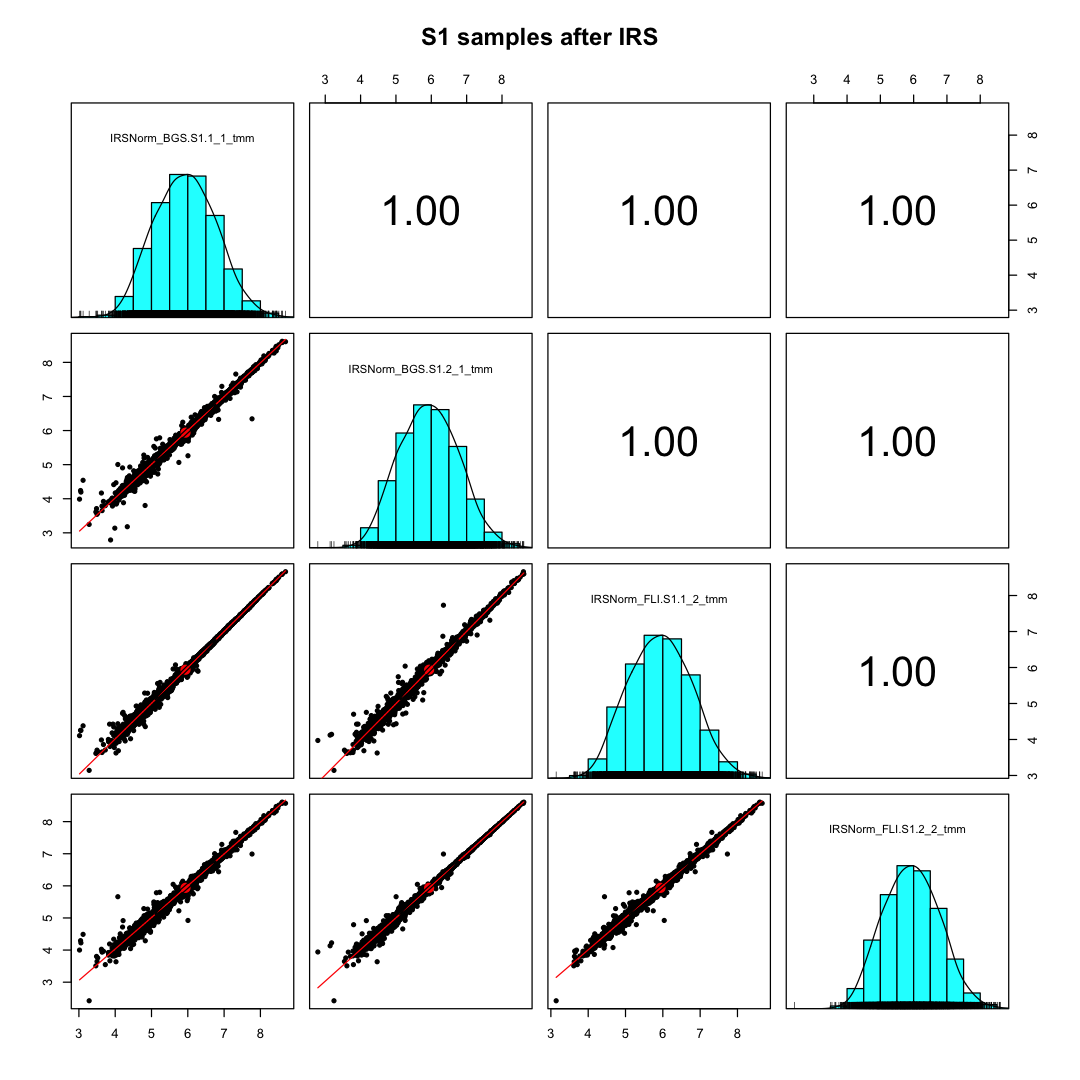

In [32]:
# check the sample-to-sample correlations
pairs.panels(log10(tmt_sl[S1]), main = "S1 samples before IRS")
pairs.panels(log10(tmt_tmm[S1]), main = "S1 samples after IRS")

#### Technical reproducibility is very high

The first two samples and the last two samples (on the diagonal) are biological replicates from the same plex (one TMT kit done at one lab). The first and third pair and the second and fourth pair are the same samples run in two different labs. There is less scatter between labs for the same sample after IRS than there are for biological replicates of mouse brain digests. We will see this pattern in the plots below, too.  

### S2 Samples

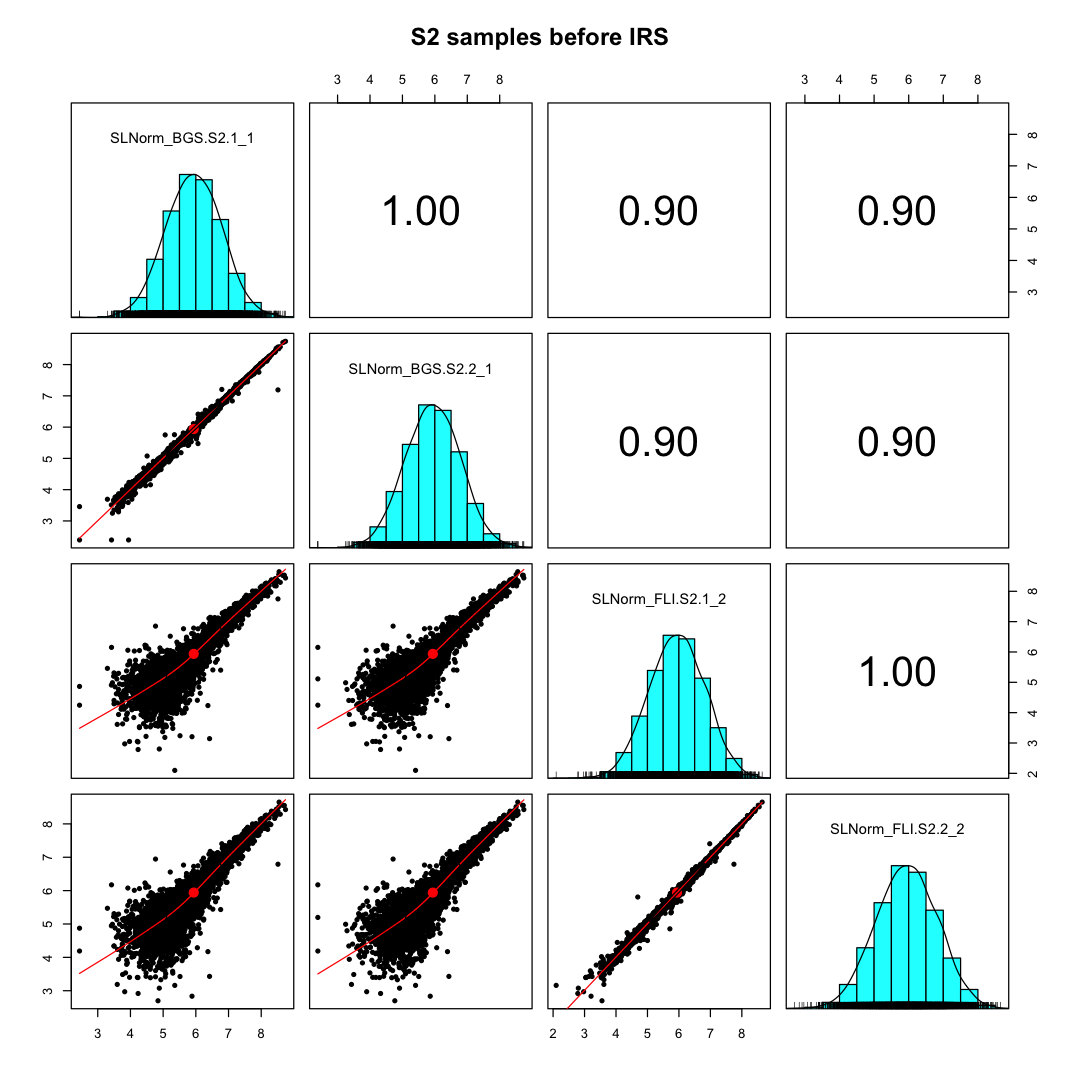

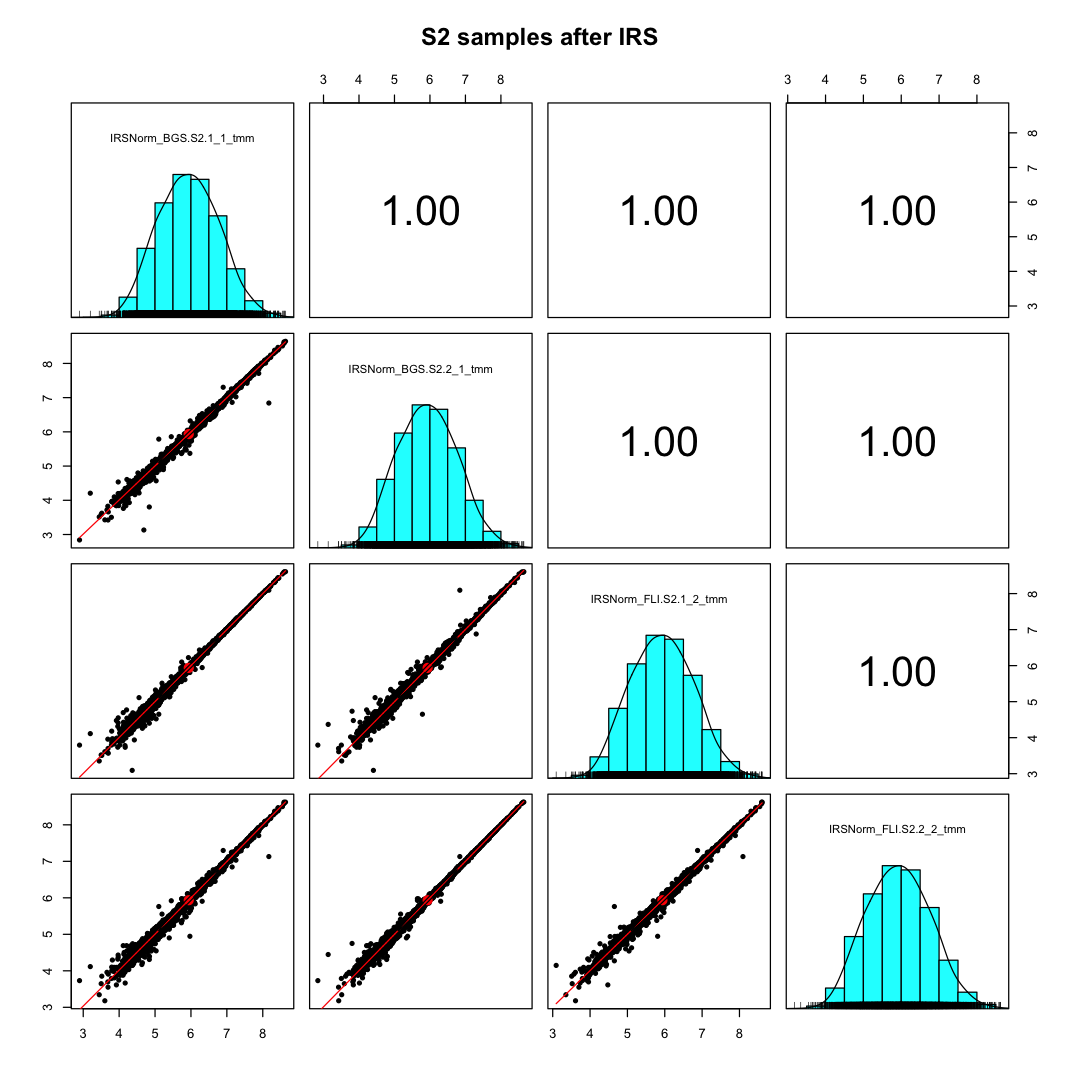

In [33]:
# check the sample-to-sample correlations
pairs.panels(log10(tmt_sl[S2]), main = "S2 samples before IRS")
pairs.panels(log10(tmt_tmm[S2]), main = "S2 samples after IRS")

### S3 Samples

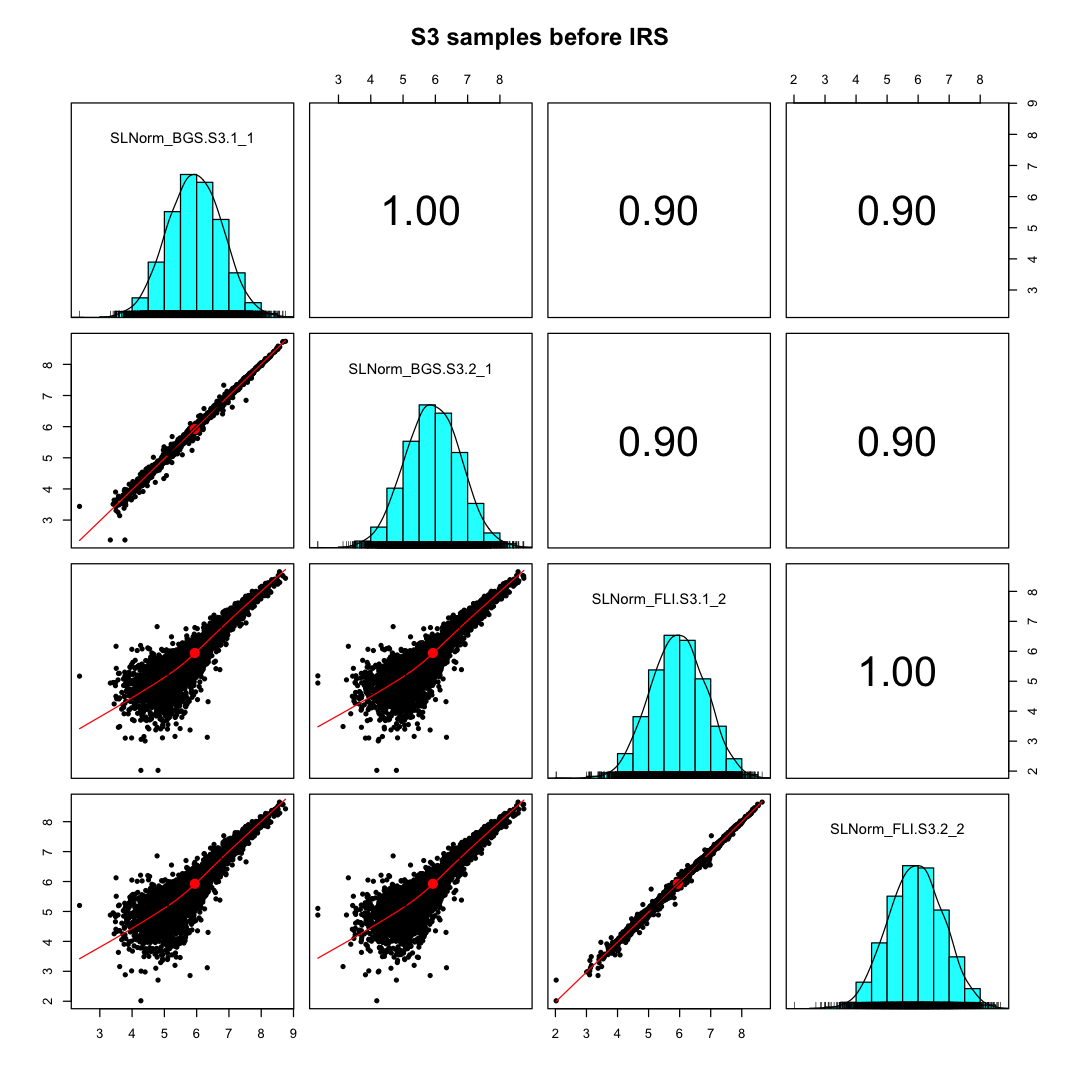

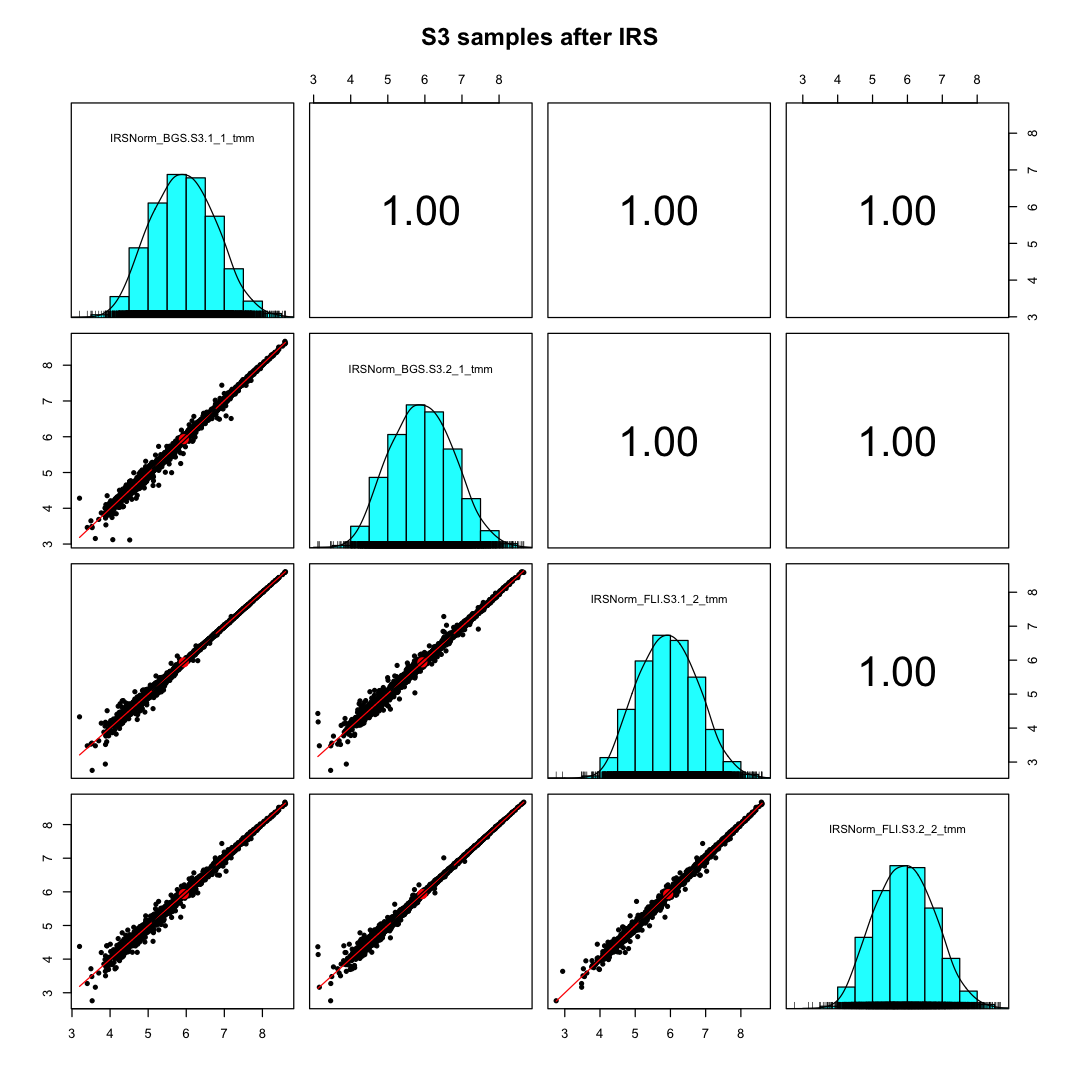

In [34]:
# check the sample-to-sample correlations
pairs.panels(log10(tmt_sl[S3]), main = "S3 samples before IRS")
pairs.panels(log10(tmt_tmm[S3]), main = "S3 samples after IRS")

### S4 Samples

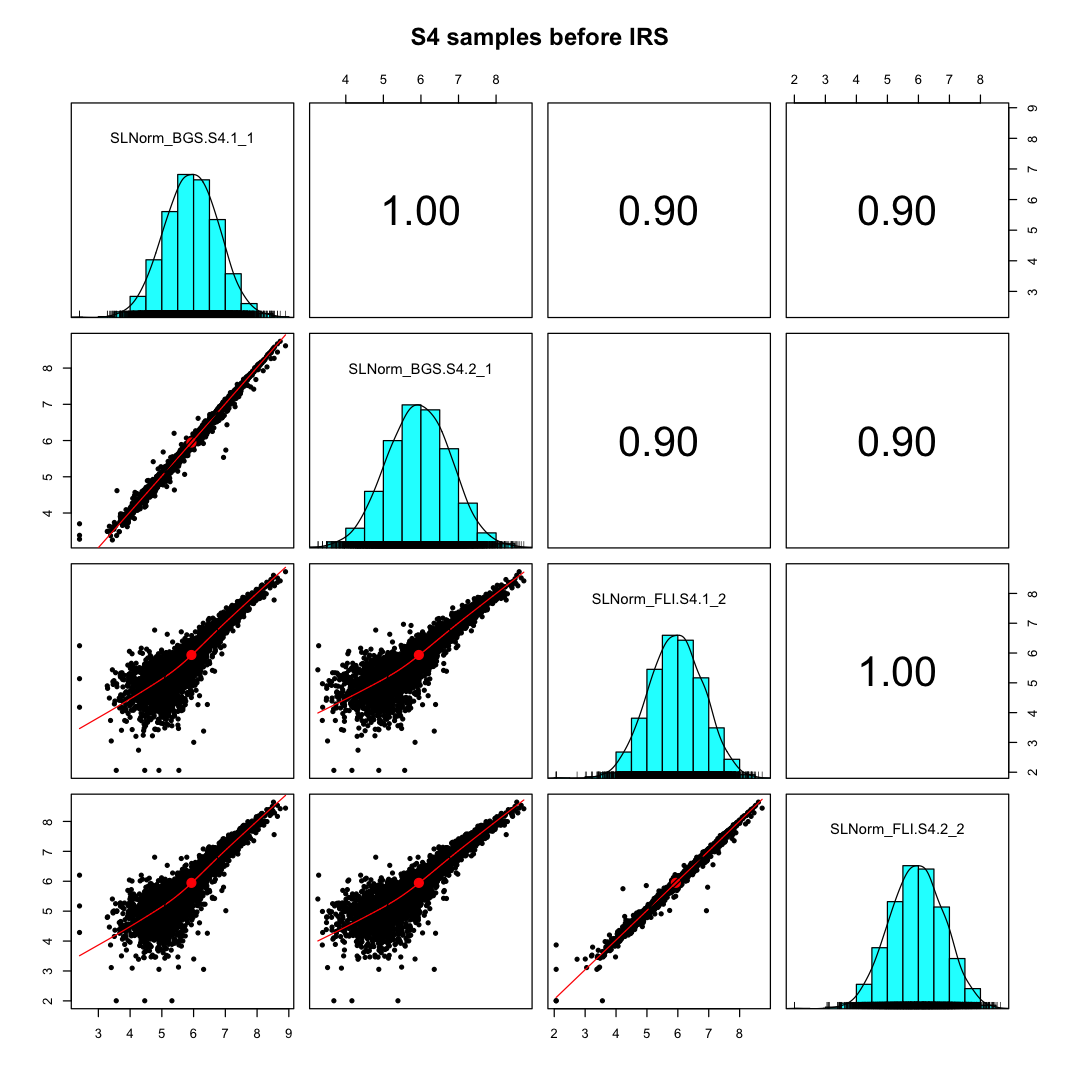

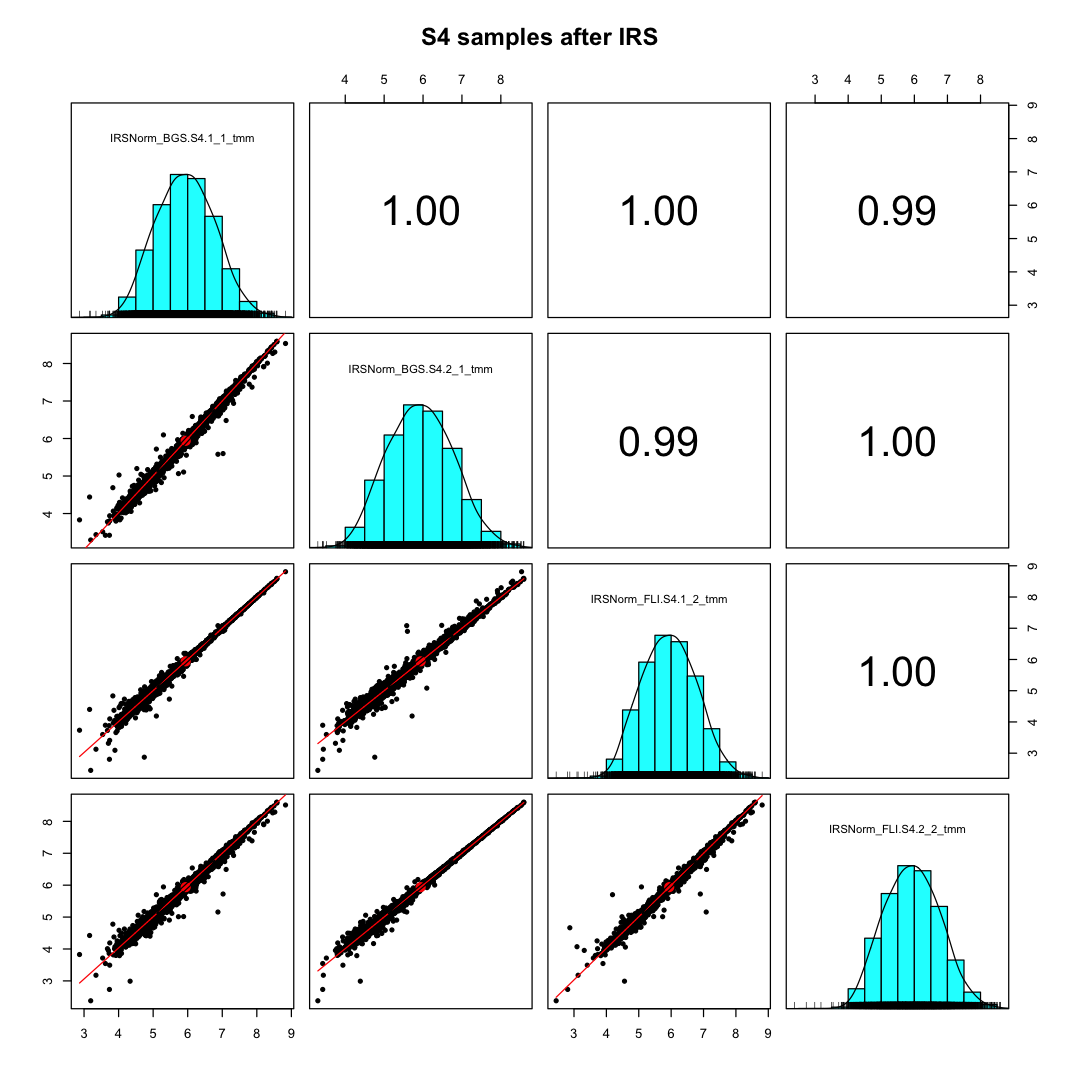

In [35]:
# check the sample-to-sample correlations
pairs.panels(log10(tmt_sl[S4]), main = "S4 samples before IRS")
pairs.panels(log10(tmt_tmm[S4]), main = "S4 samples after IRS")

## Think about the above plots

This is actually a stunning result that showcases two aspects of TMT labeling. First, protein-level reporter ion summarization is more precise that interscan reporter ion precision. Data from PSMs or peptides does not look this good. Secondly, two internal reference channels per plex is a very precise way to remove analytic platform variability associated with multiple TMT plexes (either to accommodate more samples or to validate studies in different laboratory sites). Averaging two channels per plex offers a significant improvement over using a single reference channel (also called bridge channels). 

The analytic platform does need to be identical for IRS to work. This last point is not well known. Obviously, you cannot correct all measurement issues with IRS. It does a very specific adjustment of the data. It is, however, one slick tool when it is right for the job.  

### Make average vectors to compare groups

We can do one more variation using the scatter plot grids and compare the site average vectors to each other. This will not include the proxy IRS channels, so the average is 8 samples per site. This should be dominated by the unchanged mouse background, and we should see very few proteins very far from the diagonal trend line. 

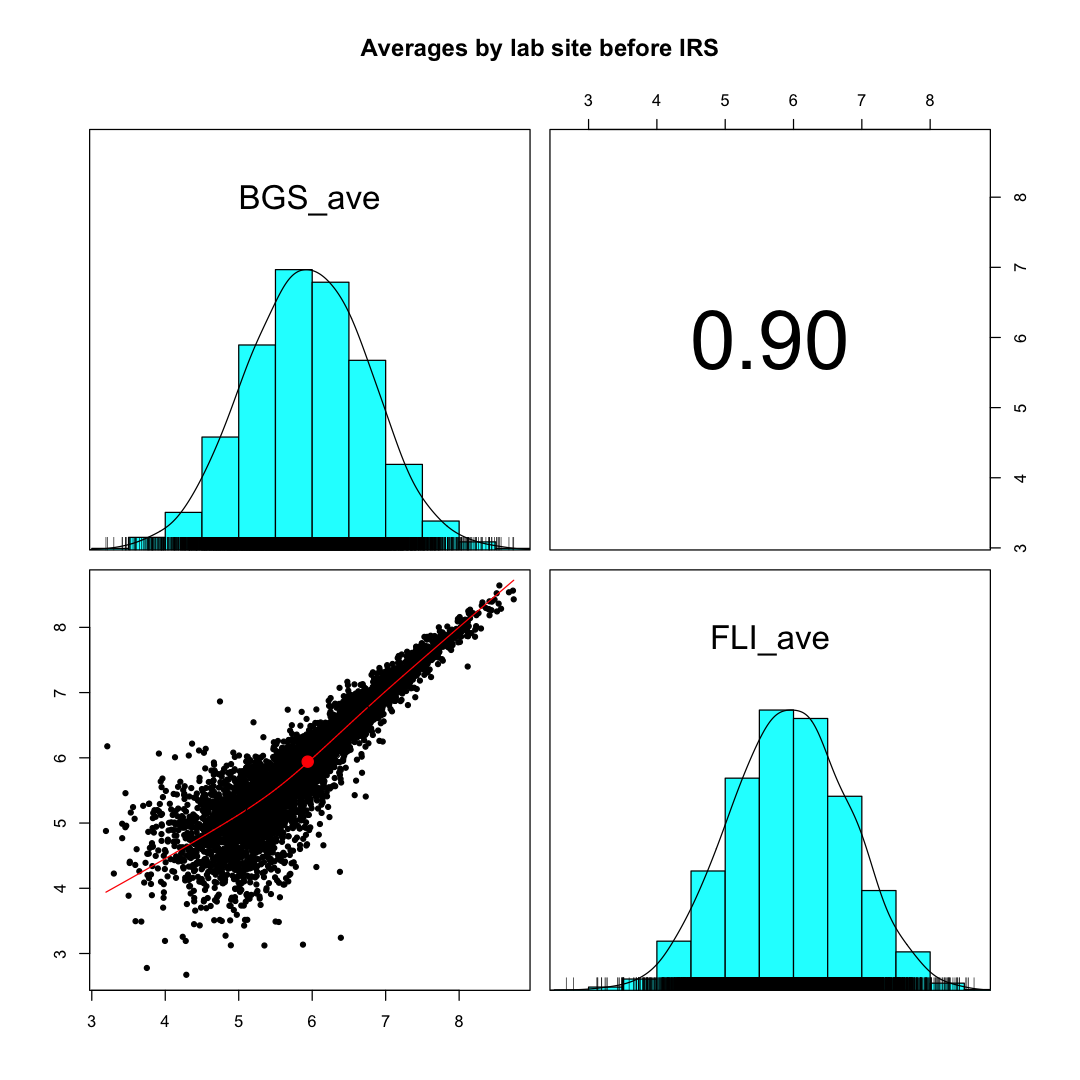

In [36]:
# make the average vectors
BGS_ave <- rowMeans(tmt_sl[BGS])
FLI_ave <- rowMeans(tmt_sl[FLI])

# Put vectors in a data frame
averages <- data.frame(BGS_ave, FLI_ave)
names(averages) <- c("BGS_ave", "FLI_ave")

# make scatter plots
pairs.panels(log10(averages), main = "Averages by lab site before IRS")

### You do not want to work with this data

Before IRS, the data between sites is basically useless. While there is some general relative abundance concordance between datasets (the R^2 is 0.9), you would have to have extremely large effect sizes to get any statistical significance.

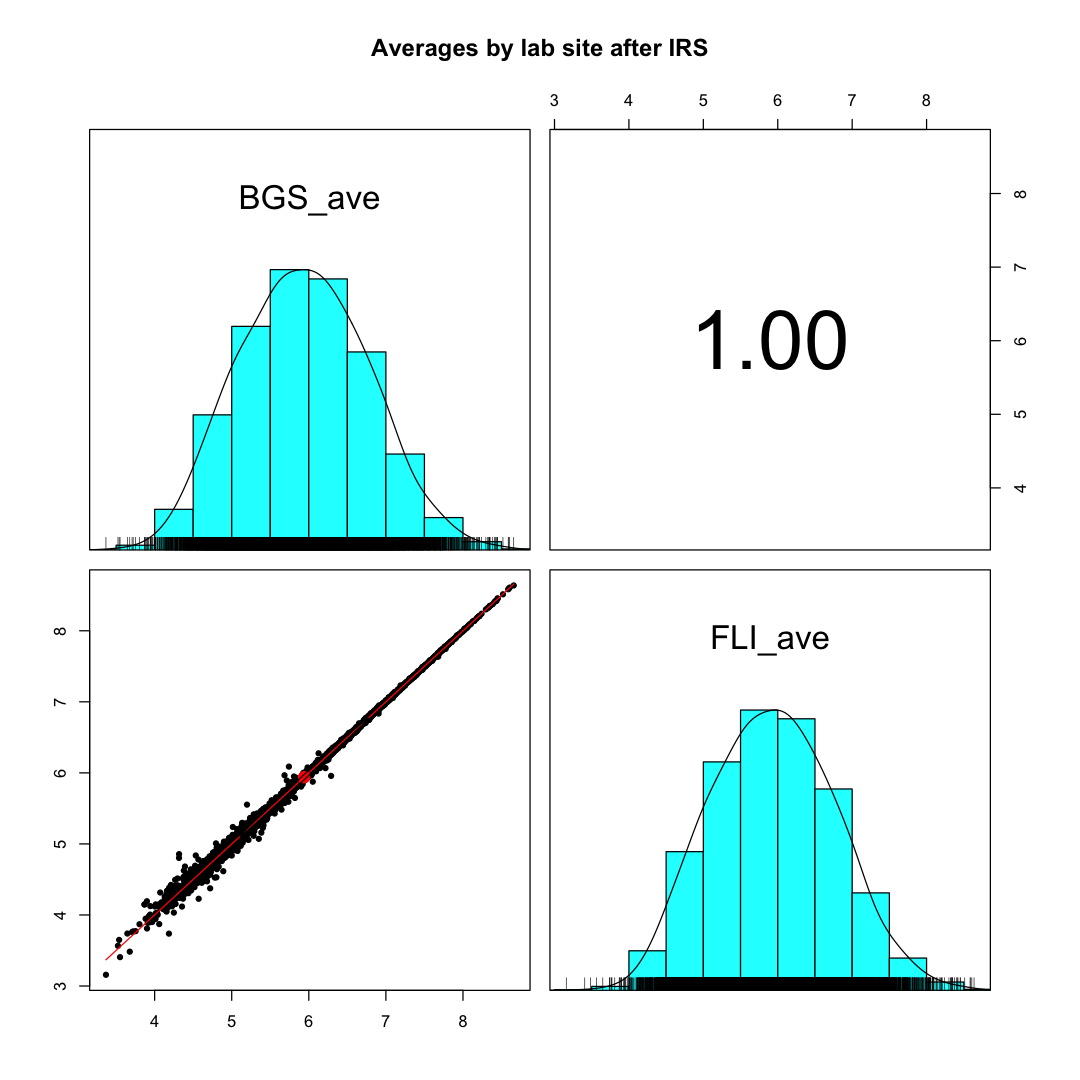

In [37]:
# make the average vectors
BGS_ave <- rowMeans(tmt_tmm[BGS])
FLI_ave <- rowMeans(tmt_tmm[FLI])

# Put vectors in a data frame
averages <- data.frame(BGS_ave, FLI_ave)
names(averages) <- c("BGS_ave", "FLI_ave")

# make scatter plots
pairs.panels(log10(averages), main = "Averages by lab site after IRS")

### Yeah! We can measure the same thing twice

Measurement platforms for TMT experiments are now very good. TMT labeling protocols have also improved and experienced bench scientists can do them reproducibly. TMT has expanded up to 18 channels. It is currently a quantitative proteomics method that is both expensive and technically demanding. The data quality can, however, be exceptional.

## <a name="summary"></a> Summary

If we ignore the UPS2 proteins, the data is 10 replicates of a very similar mouse brain background. We see how the TMT intensities cannot be directly compared between sites without correcting for the random MS2 sampling affect using the IRS method. We used the duplicate S5 samples as proxy internal reference channels. These samples were not digested, labeled, and fractionated independently in the two lab sites, so the data is more like technical replicates done on two different instruments (located in two different sites). The LC and MS systems were the same at both sites further reducing sources of variability. If we could not get excellent reproducibility of these two datasets (which we did), there would not be much hope for reproducible proteomics.

## Log the session information

In [38]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] dendextend_1.13.4 psych_2.0.7       edgeR_3.24.3      limma_3.38.3     
 [5] scales_1.1.1      forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2      
 [9] purrr_0.3.4       readr_1.3.1       tidyr_1.1.1       tibble_3.0.3     
[13] ggplot2_3.3.2     tidyverse_1.3.0  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5        locfit_1.5-9.4    lubridate_1.7.9   lattice_0.20-41  
 [5] assertthat_0.2.1  digest_0.6.25     IRdisplay_0.7.0   R6_2.4.1         
 [9] cellranger_1.1.0  repr_1.1.0   